In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import numpy as np
import scipy.optimize as opt
from scipy import interpolate
import scipy.io as sio
import scipy.special as spf
import yaml

## import diffrantion integral solver from Optics folder
work_dir = os.getcwd()
date_dir = os.path.split(work_dir)[0]
optics_folder = os.path.join(date_dir, 'Optics')
sys.path.append(optics_folder)
sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib


## Import field functions
# field_module_folder = os.path.join(date_dir, 'field_functions')             
# sys.path.append(field_module_folder)
# import far_fields as fi

## Read parameter file to obtain fields
stream = open('../curly_param.yaml','r')
parameters = yaml.load(stream)


## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

# import eqm_slns as osc

## analytic image functions
# import analytic_intensity_functions_xyz as imf

## dipole moments as functions of separation, not pulled from param file
# import p_of_d_genOr as pod

# pretty fitting
# import lmfit as lf

import anal_foc_diff_fields as afi

import coupled_dipoles as cp 

## Import physical constants
full_path_to_constant_yaml = os.path.join(date_dir,'physical_constants.yaml')
opened_constant_file = open(full_path_to_constant_yaml,'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## System background
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.

a = parameters['plasmon']['radius']
#######################################################################
## simulated image 
sensor_size = 2000*nm
# height = 2*mm  # also defines objective lens focal length 
height = .2
resolution = 100  # image grid resolution

norm_style = 'per fig'  # 'per fig' or 'across figs'

show_or_save = 'show'
# show_or_save = raw_input('( show / save ) figures? ')

file_extension = 'pdf'  # 'pdf' for mest quality

## plot parameters
plot_scale = 1/nm

#######################################################################
## Optics stuff.  

## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = 1
numerical_aperture = 1
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = 1000

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = height

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = 1.86 ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from ../curly_param.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


In [2]:
fit_result_params = (
    ## eps_inf, hbar*omega_p, hbar*gamma_nr, eps_b (not used as fit param), a_x, a_yz
    15.100176  , 10.15232758/hbar,  0.10316881/hbar, 1.0, 67.24906658*nm, 19.20816015*nm
    )
alpha0_diag_dyad = cp.sparse_polarizability_tensor(
    mass=cp.fluorophore_mass(
        ext_coef=parameters['fluorophore']['extinction_coeff'], 
        gamma=parameters['fluorophore']['mass_gamma']/hbar
        ), 
    w_res=drive_hbar_omega/hbar, 
    w=drive_hbar_omega/hbar, 
    gamma_nr=parameters['fluorophore']['test_gamma']/hbar,
    a=0, 
    eps_inf=1, 
    ebs_b=1
    )
alpha1_diag_dyad = cp.sparse_ret_prolate_spheroid_polarizability_Drude(
        omega_drive, *fit_result_params)
# alpha1_diag_dyad_no_trans = alpha1_diag_dyad
# alpha1_diag_dyad_no_trans[1,1] = 0
# alpha1_diag_dyad_no_trans[2,2] = 0


In [3]:
#### Now implemented as base class for Exp class
# def mb_p_fields(dipole_mag_array, dipole_coordinate_array):
#     ''' As of 081418,fixing: currently only treats dipole at origin.'''    
#     p = dipole_mag_array
# #     print('Inside mb_p_fields, p= ',p)
#     bfx = dipole_coordinate_array

#     v_rel_obs_x_pts = (eye[1].ravel()[:,None] - bfx.T[0]).T
#     v_rel_obs_y_pts = (eye[2].ravel()[:,None] - bfx.T[1]).T
    
#     px_fields = np.asarray(afi.E_field(0, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
#     py_fields = np.asarray(afi.E_field(np.pi/2, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
#     pz_fields = np.zeros(py_fields.shape)
# #     print('px_fields.shape=',px_fields.shape)
# #     print('p.shape=',p.shape)
#     ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
#     Ex = p[:,0,None]*px_fields[0] + p[:,1,None]*py_fields[0] + p[:,2,None]*pz_fields[0]
#     Ey = p[:,0,None]*px_fields[1] + p[:,1,None]*py_fields[1] + p[:,2,None]*pz_fields[1]
#     Ez = p[:,0,None]*px_fields[2] + p[:,1,None]*py_fields[2] + p[:,2,None]*pz_fields[2]

#     return np.array([Ex,Ey,Ez])

# def dipole_fields(locations, mol_angle=0, plas_angle=np.pi/2):
#     d = locations*nm
#     p0, p1 = cp.dipole_mags_gened(mol_angle, plas_angle, d_col=d, E_d_angle=None,
#                                   alpha0_diag=alpha0_diag_dyad,
#                                   alpha1_diag=alpha1_diag_dyad)
#     mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
#     plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

#     # p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
#     p0_unc, = cp.uncoupled_p0(mol_angle, E_d_angle=None, drive_hbar_w=drive_hbar_omega)
# #     print('p0.shape = ',p0.shape)
# #     print('p1.shape = ',p1.shape)
# #     print('p0_unc.shape = ',p0_unc.shape)
# #     p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))
#     if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
#         p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc, dipole_coordinate_array=d)
#     elif (type(mol_angle) == int or
#           type(mol_angle) == float or
#           (type(mol_angle) == np.ndarray and mol_angle.shape[0]==1)
#           ):
#         p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=d)
    
#     return [mol_E, plas_E, p0_unc_E, p0, p1]

def powers_and_angels(E):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = np.abs(E[0])**2. / drive_I
    normed_Iy = np.abs(E[1])**2. / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    

    angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)
    return [angles, Px_per_drive_I, Py_per_drive_I]

def powers_and_angels_no_interf(E1,E2):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = (np.abs(E1[0])**2. + np.abs(E2[0])**2.) / drive_I
    normed_Iy = (np.abs(E1[1])**2. + np.abs(E2[1])**2.) / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    

    angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)
    return [angles, Px_per_drive_I, Py_per_drive_I]

### functions for fitting 2D Gaussian to images

In [77]:
def twoD_Gaussian(
    X, ## tuple of meshed (x,y) values
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset
    ):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((X[0]-xo)**2) + 2*b*(X[0]-xo)*(X[1]-yo) 
        + c*((X[1]-yo)**2)))
    return g.ravel()

def misloc_data_minus_model(fit_params, *normed_raveled_image_data):
    ''' fit gaussian to data '''
    gaus = twoD_Gaussian(
        (eye[1]/nm, eye[2]/nm),
        *fit_params ## ( A, xo, yo, sigma_x, sigma_y, theta, offset)
        )
    
    return gaus - normed_raveled_image_data

def calculate_max_xy(images):
    ## calculate index of maximum in each image. 
    apparent_centroids_idx = images.argmax(axis=-1)
    ## define locations for each maximum in physical coordinate system

    x_cen = (eye[1]/nm).ravel()[apparent_centroids_idx]
    y_cen = (eye[2]/nm).ravel()[apparent_centroids_idx]
    
    ## these are locations of molecules, not the same thing I need pizel locations in eye. 
#     x_mesh, y_mesh = np.meshgrid(x,y)
#     x_cen = x_mesh.ravel()[apparent_centroids_idx]
#     y_cen = y_mesh.ravel()[apparent_centroids_idx]

    return [x_cen,y_cen]

def calculate_apparent_centroids(images):
    ## calculate index of maximum in each image. 
    num_of_images = images.shape[0]
    
    apparent_centroids_xy = np.zeros((num_of_images,2))
    
    max_positions = calculate_max_xy(images)
    
    for i in np.arange(num_of_images):
        x0 = max_positions[0][i]
        y0 = max_positions[1][i]        
        params0 = (1,x0,y0,100, 100, 0,0)
        args=tuple(images[i]/np.max(images[i]))
        fit_gaussian = opt.least_squares(misloc_data_minus_model, params0, args=args)
        resulting_fit_params = fit_gaussian['x']
        fit_result = twoD_Gaussian(
            (eye[1]/nm, eye[2]/nm), ## tuple of meshed (x,y) values
            *resulting_fit_params
            )
        centroid_xy = resulting_fit_params[1:3]
        apparent_centroids_xy[i] = centroid_xy
    ## define locations for each maximum in physical coordinate system

    return apparent_centroids_xy.T  ## returns [x_cen(s), y_cen(s)]

def image_from_E(E):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_I = np.sum(np.abs(E)**2.,axis=0) / drive_I

#     P_per_drive_I = normed_I,axis=-1) / sensor_size**2.

    return normed_I


#### and some plot stuff too...

def connectpoints(cen_x, cen_y, mol_x, mol_y, p, ax=None, zorder=1):
    x1, x2 = mol_x[p], cen_x[p]
    y1, y2 = mol_y[p], cen_y[p]
    if ax == None:
        plt.plot([x1,x2],[y1,y2],'k-', linewidth=.3, zorder=zorder)
    else: 
        ax.plot([x1,x2],[y1,y2],'k-', linewidth=.3, zorder=zorder)
        
def scatter_centroids_wLine(x_mol_loc, y_mol_loc, appar_cents, ax=None):

#     trial_images = image_from_E(E)
#     appar_cents = calculate_apparent_centroids(trial_images)

    x, y = appar_cents
    
    ## This part doesnt work right now
    el_a = 19
    el_c = 67
    quel_a = el_a + 10
    quel_c = el_c + 10
    pt_is_in_ellip = np.ones(x.shape, dtype=bool)
#     for i in np.arange(x.shape[0]):
#         if (x[i]**2./quel_a**2. +  y[i]**2./quel_c**2.) < 1:
#             pt_is_in_ellip[i] = False
    ####
    
    x_plot = x[pt_is_in_ellip]
    y_plot = y[pt_is_in_ellip]

    if ax == None:
        plt.figure(dpi=300)
        for i in np.arange(x_plot.shape[0]):
            connectpoints(x_plot, y_plot, x_mol_loc, y_mol_loc, i,zorder=2)
        
        plt.scatter(x_plot, y_plot, s=10, c='Red', zorder=3)
        plt.tight_layout()
        

    else:
        for i in np.arange(x_plot.shape[0]):
            connectpoints(x_plot, y_plot, x_mol_loc, y_mol_loc, i, ax,zorder=2)
        ax.scatter(x_plot, y_plot, s=10, c='Red', zorder=3)
        return ax
#     plt.xlim([-2000,2000])
#     plt.ylim([-2000,2000])

In [17]:
type(None)

NoneType

In [19]:
type(np.array([1,2]))
type([1,2])

list

In [20]:
def quiver_plot(x_plot, y_plot, angles, plot_limits=[-25,550],
               title=r'Apparent pol. per mol. pos.', true_mol_angle=None,
               nanorod_angle=0):
    if type(true_mol_angle) == NoneType: true_mol_angle = angles
        
    el_a = 19
    el_c = 67
    quel_a = el_a + 10
    quel_c = el_c + 10
    pt_is_in_ellip = np.ones(x_plot.shape, dtype=bool)
#     for i in np.arange(x_plot.shape[0]):
#         if (x_plot[i]**2./quel_a**2. +  y_plot[i]**2./quel_c**2.) < 1:
#             pt_is_in_ellip[i] = False
    
    x_plot = x_plot[pt_is_in_ellip]
    y_plot = y_plot[pt_is_in_ellip]
    angles = angles[pt_is_in_ellip]
    
    fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(3.25,3), dpi=300, 
                                       gridspec_kw = {'width_ratios':[6, 0.5]}
                                      )

    cmap = mpl.cm.nipy_spectral
    
    ## Mark molecule locations
    scat_tr = ax0.scatter(x_plot, y_plot, s=3, 
                    color='black',
    #                    cmap='inferno',
    #                    clim = [0, np.pi/2], 
#                        width=0.005,
#                        scale=20,
            #            scale_units='width',
#                        pivot='mid',
    #                   linewidth=100.,
#                       headaxislength=0.0,
#                       headlength=0.0
                      )
    ## mark true orientation
    quiv_tr = ax0.quiver(x_plot, y_plot, np.cos(true_mol_angle),np.sin(true_mol_angle), 
                    color='black',
    #                    cmap='inferno',
    #                    clim = [0, np.pi/2], 
                       width=0.005,
                       scale=15,
            #            scale_units='width',
                       pivot='mid',
    #                   linewidth=100.,
                      headaxislength=0.0,
                      headlength=0.0
                      )
    
    ## Mark apparent orientation
    quiv_ap = ax0.quiver(x_plot, y_plot, 
                      np.cos(angles),
                      np.sin(angles), 
                      angles,
                      cmap=cmap,
                      clim = [0, np.pi/2], 
                      width=0.01,
                      scale=12,
            #            scale_units='width',
                      pivot='mid',
                      zorder=4,
                      headaxislength=2.5,
                      headlength=2.5,
                      headwidth=2.5
                      )

    ax0.axis('equal')
    ax0.set_xlim(plot_limits)
    ax0.set_ylim(plot_limits)
    ax0.set_title(title)
    ax0.set_xlabel('x [nm]')
    ax0.set_ylabel('y [nm]')

    norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

    cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label(r'observed angle $\phi$')
#     plas_dot = ax0.scatter(0,0,color='k',s=30)
    cb1.set_ticks([0, np.pi/8, np.pi/4, np.pi/8 * 3, np.pi/2])
    cb1.set_ticklabels([r'$0$', r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])

#     fig.tight_layout()
    
    quiver_axis_handle = ax0
    
    
    if nanorod_angle == np.pi/2:
        #### Draw rod
        circle = mpl.patches.Circle((0, 24), 20, facecolor='Gold',
                    edgecolor='Black', linewidth=0)
        bot_circle = mpl.patches.Circle((0, -24), 20, facecolor='Gold',
                    edgecolor='Black', linewidth=0)
        rect = mpl.patches.Rectangle((-20,-24), 40, 48, angle=0.0, facecolor='Gold',
                    edgecolor='Black', linewidth=0)

        ax0.add_patch(circle)
        ax0.add_patch(rect)
        ax0.add_patch(bot_circle)
    
    ## model ellipsoid
    ellip = mpl.patches.Ellipse((0,0), 2*el_c, 2*el_a, angle=nanorod_angle*180/np.pi, fill=False, edgecolor='Black',linestyle='--')
    ax0.add_patch(ellip)
    return [quiver_axis_handle]

In [21]:
def calculate_mislocalization_magnitude(x_cen, y_cen, x_mol, y_mol):
    misloc = ( (x_cen-x_mol)**2. + (y_cen-y_mol)**2. )**(0.5)
    return misloc

 

In [89]:
class BaseTest:
    def __init__(self, a=1):
        self.a = a
        
    def test_method(self, b):
        return self.a + b 

In [90]:
class ChildTest(BaseTest):
    def __init__(self, c, a=1):
        super().__init__()
        self.c = c
        
    def child_test_method(self, b):
        return self.c + b

In [91]:
tint = ChildTest(4)

In [92]:
tint.test_method(3)

4

In [94]:
tint.child_test_method(3)

7

In [161]:
class CoupledDipoles:
    
    def __init__(self, x_obv_grid=eye[1], y_obv_grid=eye[2]):
        self.x_obv_grid = x_obv_grid
        self.y_obv_grid = y_obv_grid
        
    def mb_p_fields(self, dipole_mag_array, dipole_coordinate_array):
        ''' As of 081418,fixing: currently only treats dipole at origin.'''    
        p = dipole_mag_array
    #     print('Inside mb_p_fields, p= ',p)
        bfx = dipole_coordinate_array

        v_rel_obs_x_pts = (self.x_obv_grid.ravel()[:,None] - bfx.T[0]).T
        v_rel_obs_y_pts = (self.y_obv_grid.ravel()[:,None] - bfx.T[1]).T

        px_fields = np.asarray(afi.E_field(0, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
        py_fields = np.asarray(afi.E_field(np.pi/2, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
        pz_fields = np.zeros(py_fields.shape)
    #     print('px_fields.shape=',px_fields.shape)
    #     print('p.shape=',p.shape)
        ## returns [Ex, Ey, Ez] for dipoles oriented along cart units

        Ex = p[:,0,None]*px_fields[0] + p[:,1,None]*py_fields[0] + p[:,2,None]*pz_fields[0]
        Ey = p[:,0,None]*px_fields[1] + p[:,1,None]*py_fields[1] + p[:,2,None]*pz_fields[1]
        Ez = p[:,0,None]*px_fields[2] + p[:,1,None]*py_fields[2] + p[:,2,None]*pz_fields[2]

        return np.array([Ex,Ey,Ez])

    def dipole_fields(self, locations, mol_angle=0, plas_angle=np.pi/2):
        d = locations*nm
        p0, p1 = cp.dipole_mags_gened(mol_angle, plas_angle, d_col=d, E_d_angle=None,
                                      alpha0_diag=alpha0_diag_dyad,
                                      alpha1_diag=alpha1_diag_dyad)
        mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
        plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

        # p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
        p0_unc, = cp.uncoupled_p0(mol_angle, E_d_angle=None, drive_hbar_w=drive_hbar_omega)
    #     print('p0.shape = ',p0.shape)
    #     print('p1.shape = ',p1.shape)
    #     print('p0_unc.shape = ',p0_unc.shape)
    #     p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc, dipole_coordinate_array=d)
        elif (type(mol_angle) == int or
              type(mol_angle) == float or
              type(mol_angle) == np.float64 or
              (type(mol_angle) == np.ndarray and mol_angle.shape[0]==1)
              ):
            p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=d)
#         print(type(mol_angle))
        return [mol_E, plas_E, p0_unc_E, p0, p1]

In [228]:
class MolCoupNanoRodExp(CoupledDipoles):
    ''' Collect focused+diffracted far-field information from molecules nearby a nanorod '''
    
    ## set up inverse mapping from observed -> true angle for signle molecule in the plane. 
    saved_mapping = np.loadtxt('obs_pol_vs_true_angle.txt')
    true_ord_angles, obs_ord_angles =  saved_mapping.T
    #from scipy import interpolate
    f = interpolate.interp1d(true_ord_angles,obs_ord_angles)
    f_inv = interpolate.interp1d(
        obs_ord_angles[:251],
        true_ord_angles[:251],
        bounds_error=False,
        fill_value=(0,np.pi/2)
        )

        
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2, 
                 x_obv_grid=eye[1], y_obv_grid=eye[2]):
        super().__init__(x_obv_grid, y_obv_grid)
        self.mol_locations = locations
        self.mol_angles = mol_angle
        self.rod_angle = plas_angle
        
        #### Filtering out molecules in region of fluorescence quenching 
        self.el_a = 19 ## ranorod degenerate radius
        self.el_c = 67
        self.quel_a = self.el_a + 10 ## define quenching region
        self.quel_c = self.el_c + 10
        self.input_x_mol = locations[:,0]
        self.input_y_mol = locations[:,1]
        
        self.pt_is_in_ellip = self.mol_too_close()
        ## select molecules outside region,
        self.mol_locations = locations[self.pt_is_in_ellip]
        ## select molecule angles if listed per molecule, 
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            self.mol_angles = mol_angle[self.pt_is_in_ellip]
        else: self.mol_angles = mol_angle
        
        (self.mol_E, 
         self.plas_E, 
         self.p0_unc_E, 
         self.p0, 
         self.p1) = self.dipole_fields(self.mol_locations, self.mol_angles, self.rod_angle)
        
        self.trial_images = image_from_E(self.mol_E + self.plas_E )

        self.default_plot_limits = [
            np.min(self.mol_locations)-((np.max(self.mol_locations)-np.min(self.mol_locations))*.1),
            np.max(self.mol_locations)+((np.max(self.mol_locations)-np.min(self.mol_locations))*.1)]
        
    def calculate_localization(self, save_fields=True):
        ## should move this to a method, takes too long to initialize class. 
        self.appar_cents = calculate_apparent_centroids(self.trial_images)
        self.x_cen, self.y_cen = self.appar_cents
        if save_fields == False:
            del self.mol_E
            del self.plas_E
    
    def calculate_polarization(self):
        ## Calculate polarization with beam splitter
        self.angles, self.Px_per_drive_I, self.Py_per_drive_I = powers_and_angels(
            self.mol_E + self.plas_E
            )
        self.mispol_angle= MolCoupNanoRodExp.f_inv(self.angles)

        
#     def in_quench_zone(self):
#         pt_is_in_ellip = np.ones(self.input_x_mol.shape, dtype=bool) ## initialize index array
#         for i in np.arange(locations[:,0].shape[0]):  
#             ## currently works only if nanorod is vertically oriented
#             if (self.input_x_mol[i]**2./self.quel_a**2. +  self.input_y_mol[i]**2./self.quel_c**2.) < 1:
#                 pt_is_in_ellip[i] = False
#         return pt_is_in_ellip
    
    def mol_too_close(self):
        rotated_x = np.cos(self.rod_angle)*self.input_x_mol + np.sin(self.rod_angle)*self.input_y_mol
        rotated_y = -np.sin(self.rod_angle)*self.input_x_mol + np.cos(self.rod_angle)*self.input_y_mol
        long_quench_radius = self.quel_c
        short_quench_radius = self.quel_a
        rotated_ellip_eq = rotated_x**2./long_quench_radius**2 + rotated_y**2./short_quench_radius**2
        return (rotated_ellip_eq > 1)

    def plot_mispol_map(self, plot_limits=None):
        if plot_limits == None: plot_limits = self.default_plot_limits
        if not hasattr(self, 'mispol_angle'):
            self.calculate_polarization()
        quiv_ax, = quiver_plot(self.mol_locations[:,0], self.mol_locations[:,1], self.mispol_angle, plot_limits,
                              true_mol_angle=self.mol_angles, nanorod_angle = self.rod_angle)
        return quiv_ax
    
    def plot_mispol_map_wMisloc(self, plot_limits=None):
        if not hasattr(self, 'appar_cents'):
            self.calculate_localization()
        if plot_limits == None: plot_limits = self.default_plot_limits
        quiv_ax = self.plot_mispol_map(plot_limits)
        scatter_centroids_wLine(self.mol_locations[:,0], self.mol_locations[:,1],
                                self.appar_cents, quiv_ax)
        
    def plot_mislocalization_magnitude_correlation(self):
        if not hasattr(self, 'appar_cents'):
            self.calculate_localization()
        self.misloc_mag = calculate_mislocalization_magnitude(
            self.x_cen, self.y_cen, self.mol_locations[:,0], self.mol_locations[:,1]
            )
    
        plt.figure(dpi=300)
        plt.scatter(self.misloc_mag, mispol_angle, s=10, c='Black', zorder=3)
        plt.tight_layout()
        plt.xlabel('Magnitude of mislocalization [nm]')
        plt.ylabel('Apparent angle [deg]')
        plt.yticks([0,  np.pi/8,  np.pi/4, np.pi/8 *3, np.pi/2],
                   ['0','22.5','45','57.5','90'])

    def plot_fields(self, ith_molecule):
        plt.figure(figsize=(3,3),dpi=600)
        plt.pcolor(eye[1]/nm,eye[2]/nm,(self.trial_images[ith_molecule,:]).reshape(eye[1].shape))
        plt.colorbar()
        plt.title(r'$|E|^2/|E_\mathrm{inc}|^2$')
        plt.xlabel(r'x [nm]')
        plt.ylabel(r'y [nm]')
#         plt.quiver(self.mol_locations[ith_molecule, 0], self.mol_locations[ith_molecule, 1],
#                    np.cos(self.mol_angles[ith_molecule]),np.sin(self.mol_angles[ith_molecule]), 
#                    color='white',pivot='middle')

In [229]:
def random_ori_mol_placement(x_min=0, x_max=350, y_min=0, y_max=350, mol_grid_pts_1D = 10):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
    random_mol_angles_0To360= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, random_mol_angles_0To360]

In [230]:
locations, angles = random_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 3)
test_instance3 = MolCoupNanoRodExp(locations, angles)

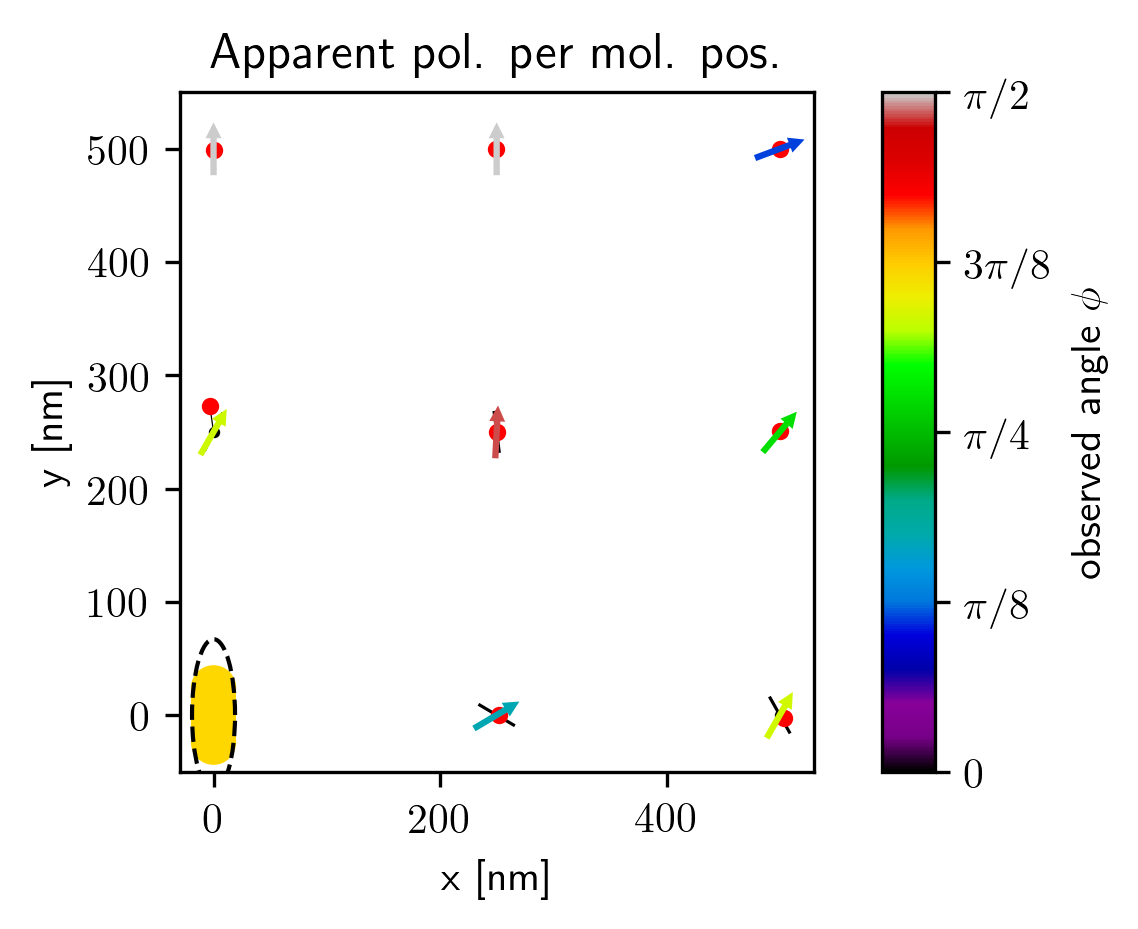

In [231]:
test_instance3.plot_mispol_map_wMisloc()

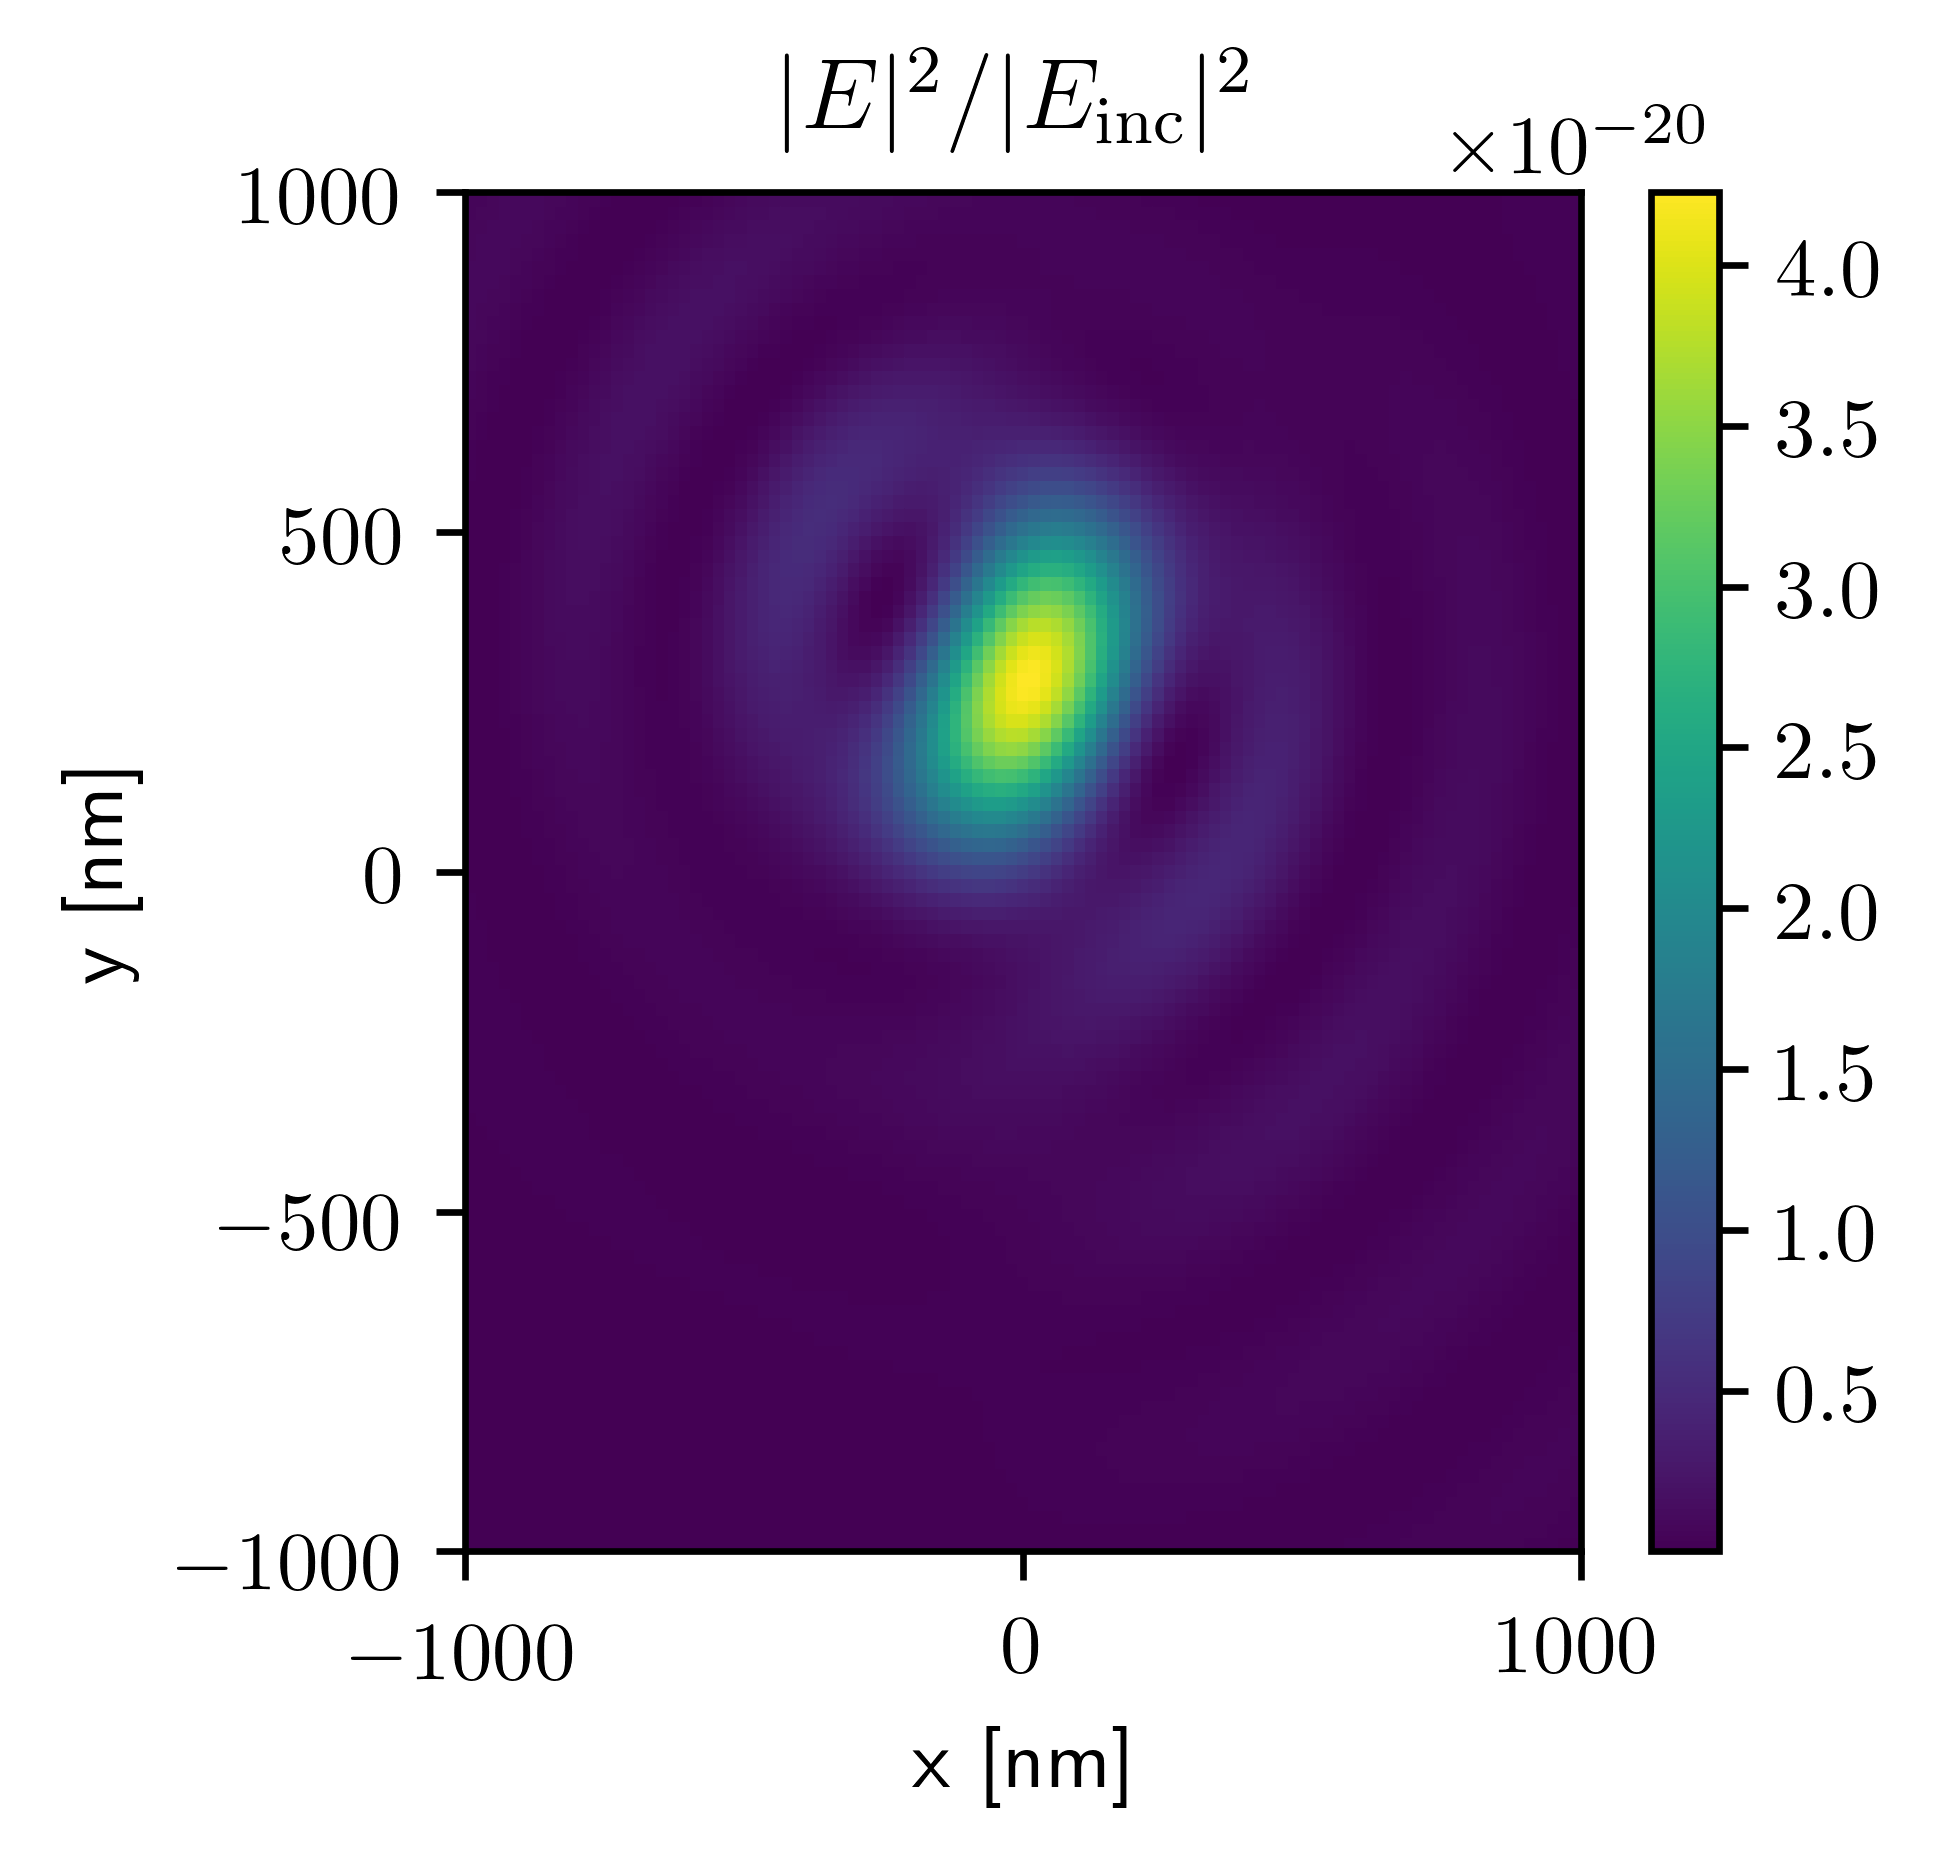

In [232]:
test_instance3.plot_fields(0)

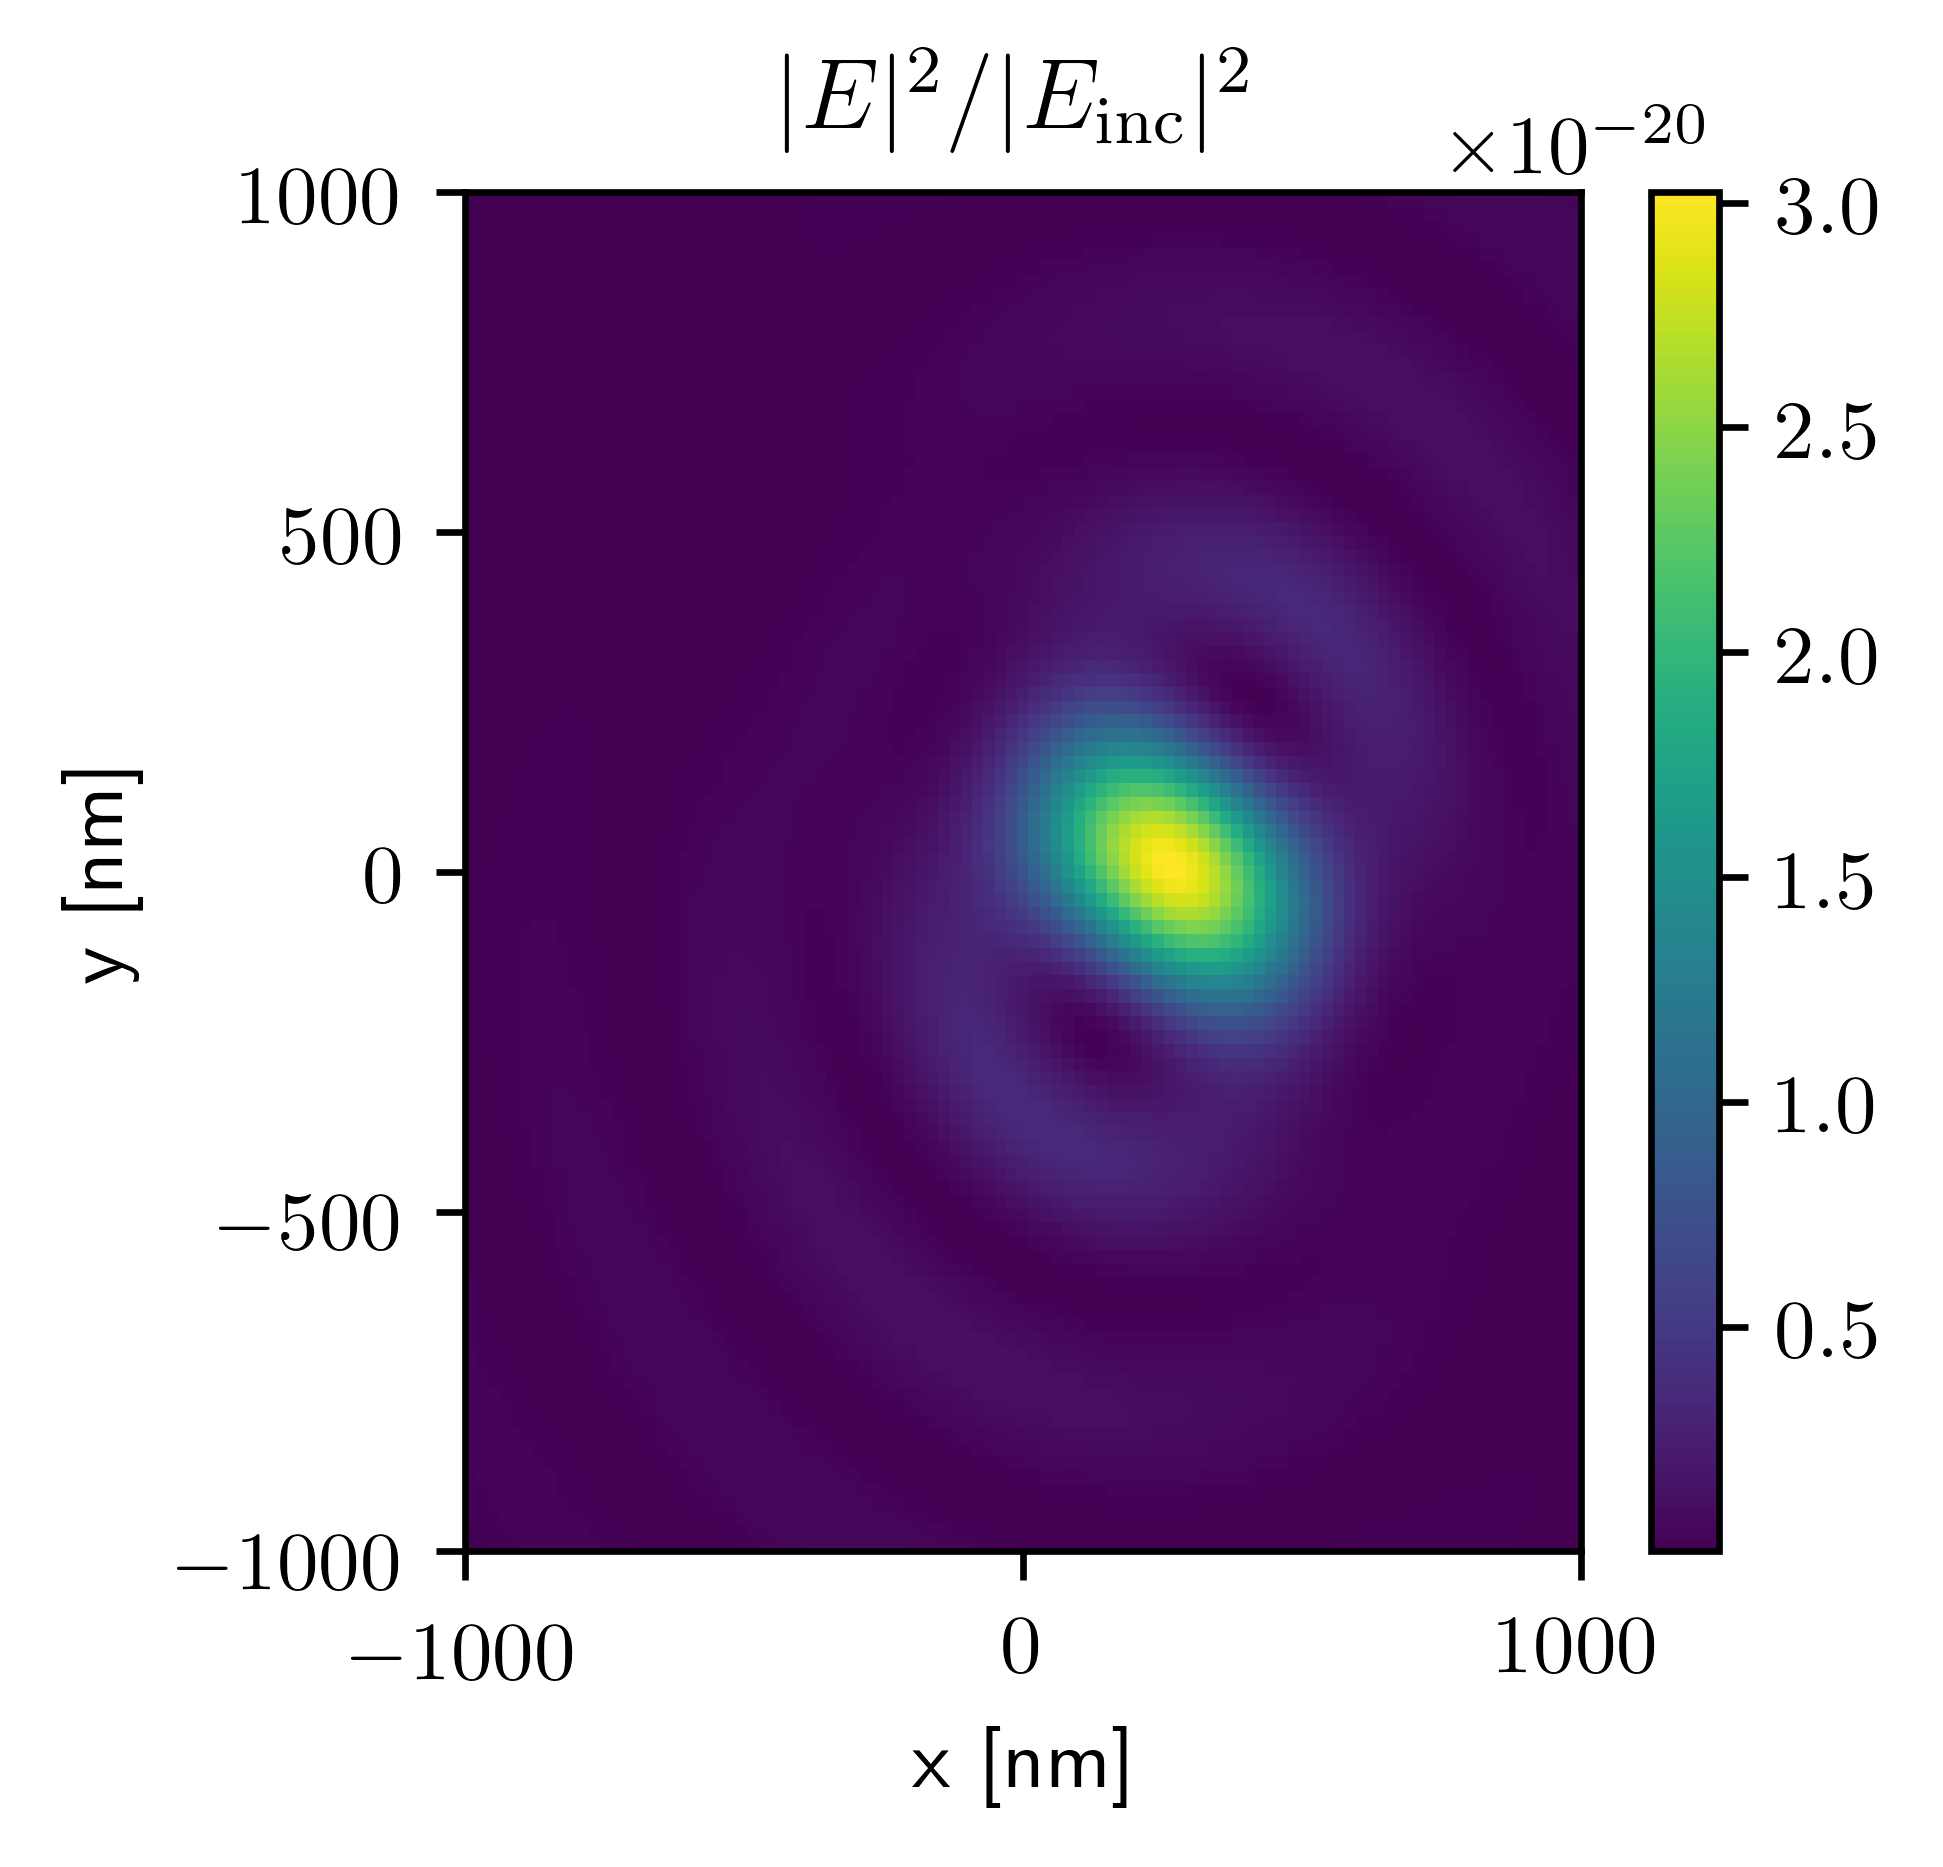

In [233]:
test_instance3.plot_fields(2)

## Fit function for model fields. 

In [234]:
test_instance3.trial_images.shape

(8, 10000)

In [235]:
angles.shape

(9,)

In [236]:
one_location = np.array([[100,0,0]])
one_angle = np.pi/2
test_instance_one_mol = MolCoupNanoRodExp(one_location, one_angle)

In [237]:
test_instance_one_mol.trial_images.shape

(1, 10000)

In [238]:
type(np.array([[1,1,0]])) == np.ndarray

True

In [239]:
type([1,0,0])

list

In [240]:
testlist=[1,0,0]
np.array([testlist])

array([[1, 0, 0]])

In [241]:
np.atleast_2d(np.array([1,0,0]))

array([[1, 0, 0]])

In [242]:
np.atleast_2d([1,0,0])

array([[1, 0, 0]])

In [255]:
# MolCoupNanoRodExp(locations, mol_angle=0, plas_angle=np.pi/2, x_obv_grid=eye[1], y_obv_grid=eye[2])
class FitModelToData:
    ''' Class to contain fitting functions that act on class 'MolCoupNanoRodExp' 
    as well as variables that are needed by 'MolCoupNanoRodExp' 
    '''
    def __init__(self, image_data):
        self.mol_angle=0 
        self.rod_angle=np.pi/2
        self.x_obv_grid=eye[1]
        self.y_obv_grid=eye[2]
        
        self.image_data = image_data


    def fit_model_to_image_data(self):
        ## calculate index of maximum in each image, going to use this for the initial position guess 
        num_of_images = self.image_data.shape[0]

        resulting_fit_param_array = np.zeros((num_of_images,3))

        max_positions = calculate_max_xy(self.image_data)

        for i in np.arange(num_of_images):
            ## establish initial guesses and stash in 'params0'
#             ini_x = max_positions[0][i]
#             ini_y = max_positions[1][i]  
            ini_x = 100
            ini_y = 100
            ini_mol_orientation = self.mol_angle
            params0 = (ini_x, ini_y, ini_mol_orientation)
            tuple_normed_image_data=tuple(self.image_data[i]/np.max(self.image_data[i]))
            optimized_fit = opt.least_squares(self._misloc_data_minus_model, params0, 
                                              args=tuple_normed_image_data)
            resulting_fit_param_array[i] = optimized_fit['x']

        return resulting_fit_param_array  ## returns [x_cen(s), y_cen(s)]

    def _misloc_data_minus_model(self, fit_params, *normed_raveled_image_data):
        ''' fit image model to data.
        arguments;
            fit_params = [ini_x, ini_y, ini_mol_orintation]
                'ini_x' : units of nm from plas position
                'ini_y' : units of nm from plas position
                'ini_mol_orintation' : units of radians counter-clock from +x
        '''
        
        raveled_model = self.raveled_model_of_params(fit_params)
        normed_raveled_model = raveled_model/np.max(raveled_model)
        
        return normed_raveled_model - normed_raveled_image_data
    
    def raveled_model_of_params(self, fit_params):
        locations = np.array([[fit_params[0], fit_params[1], 0]])
        exp_instance = MolCoupNanoRodExp(locations, 
                                         mol_angle=fit_params[2], 
                                         plas_angle=self.rod_angle, 
                                         x_obv_grid=self.x_obv_grid/nm, 
                                         y_obv_grid=self.y_obv_grid/nm)
        raveled_model = exp_instance.trial_images[0].ravel()
        return raveled_model
    
    def plot_image_from_params(self, fit_params):
        image = self.raveled_model_of_params(fit_params).reshape(self.x_obv_grid.shape)
        plt.figure(figsize=(3,3),dpi=600)
        plt.pcolor(self.x_obv_grid/nm,self.y_obv_grid/nm,image)
        plt.colorbar()
        plt.title(r'$|E|^2/|E_\mathrm{inc}|^2$')
        plt.xlabel(r'x [nm]')
        plt.ylabel(r'y [nm]')
#         plt.quiver(self.mol_locations[ith_molecule, 0], self.mol_locations[ith_molecule, 1],
#                    np.cos(self.mol_angles[ith_molecule]),np.sin(self.mol_angles[ith_molecule]), 
#                    color='white',pivot='middle')
        

Testing fits

In [244]:
def fixed_ori_mol_placement(x_min=0, x_max=350, y_min=0, y_max=350, mol_grid_pts_1D = 10, mol_angle=0):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
#     random_mol_angles= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, mol_angle]

In [256]:
locations_h, angles_h = fixed_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 3)
test_exp_instance_h = MolCoupNanoRodExp(locations_h, angles_h)

In [257]:
test_fit_inst = FitModelToData(test_exp_instance_h.trial_images)

In [258]:
test_fit_inst.fit_model_to_image_data()

array([[-2.25850636e-13,  2.50000000e+02, -1.22666536e-16],
       [ 2.82719562e-11,  5.00000000e+02,  5.08255025e-15],
       [ 2.50000000e+02,  3.03764600e-09,  3.25448332e-12],
       [ 2.50000000e+02,  2.50000000e+02, -8.04250471e-17],
       [ 2.50000000e+02,  5.00000000e+02, -3.14159265e+00],
       [ 5.00000000e+02, -2.79464127e-11,  2.60987018e-13],
       [ 5.00000000e+02,  2.50000000e+02, -9.83549661e-16],
       [ 5.00000000e+02,  5.00000000e+02, -3.14159265e+00]])

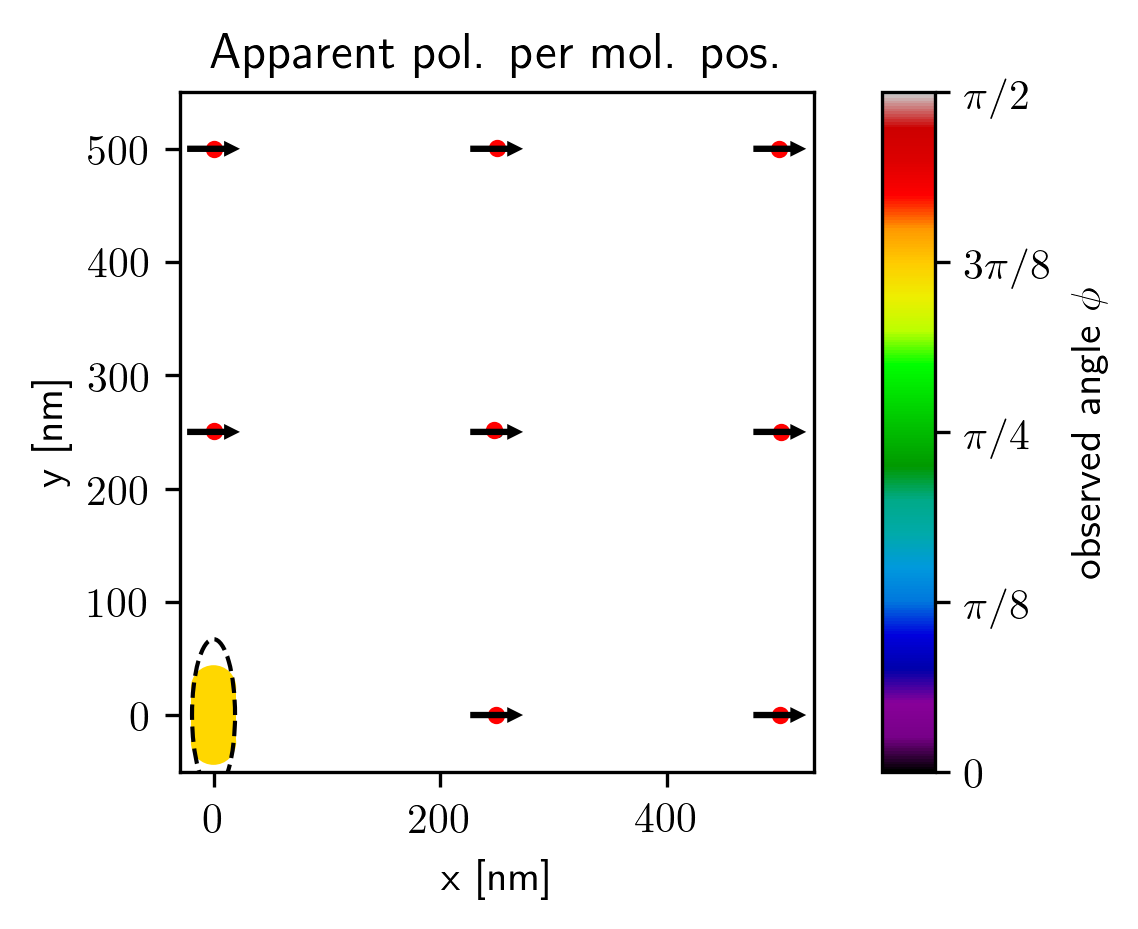

In [260]:
test_exp_instance_h.plot_mispol_map_wMisloc()

In [270]:
locations_h_closer, angles_h_closer = fixed_ori_mol_placement(
    x_min=0, x_max=200, y_min=0, y_max=200, mol_grid_pts_1D = 3)
test_exp_instance_h_closer = MolCoupNanoRodExp(locations_h_closer, angles_h_closer)
test_fit_inst_closer = FitModelToData(test_exp_instance_h_closer.trial_images)
closer_fit_results = test_fit_inst_closer.fit_model_to_image_data()

In [271]:
np.round(closer_fit_results)

array([[ -0., 100.,  -0.],
       [  0., 200.,   0.],
       [100.,   0.,  -0.],
       [100., 100.,   0.],
       [100., 200.,  -0.],
       [200.,  -0.,   0.],
       [200., 100.,  -0.],
       [200., 200.,  -0.]])

In [272]:
test_exp_instance_h_closer.calculate_localization()

In [274]:
gaussian_fit_results = test_exp_instance_h_closer.appar_cents.T

In [275]:
np.round(gaussian_fit_results)

array([[  0., 102.],
       [  0., 201.],
       [ 95.,  -0.],
       [ 76.,  87.],
       [ 95., 199.],
       [199.,   0.],
       [195.,  99.],
       [195., 201.]])

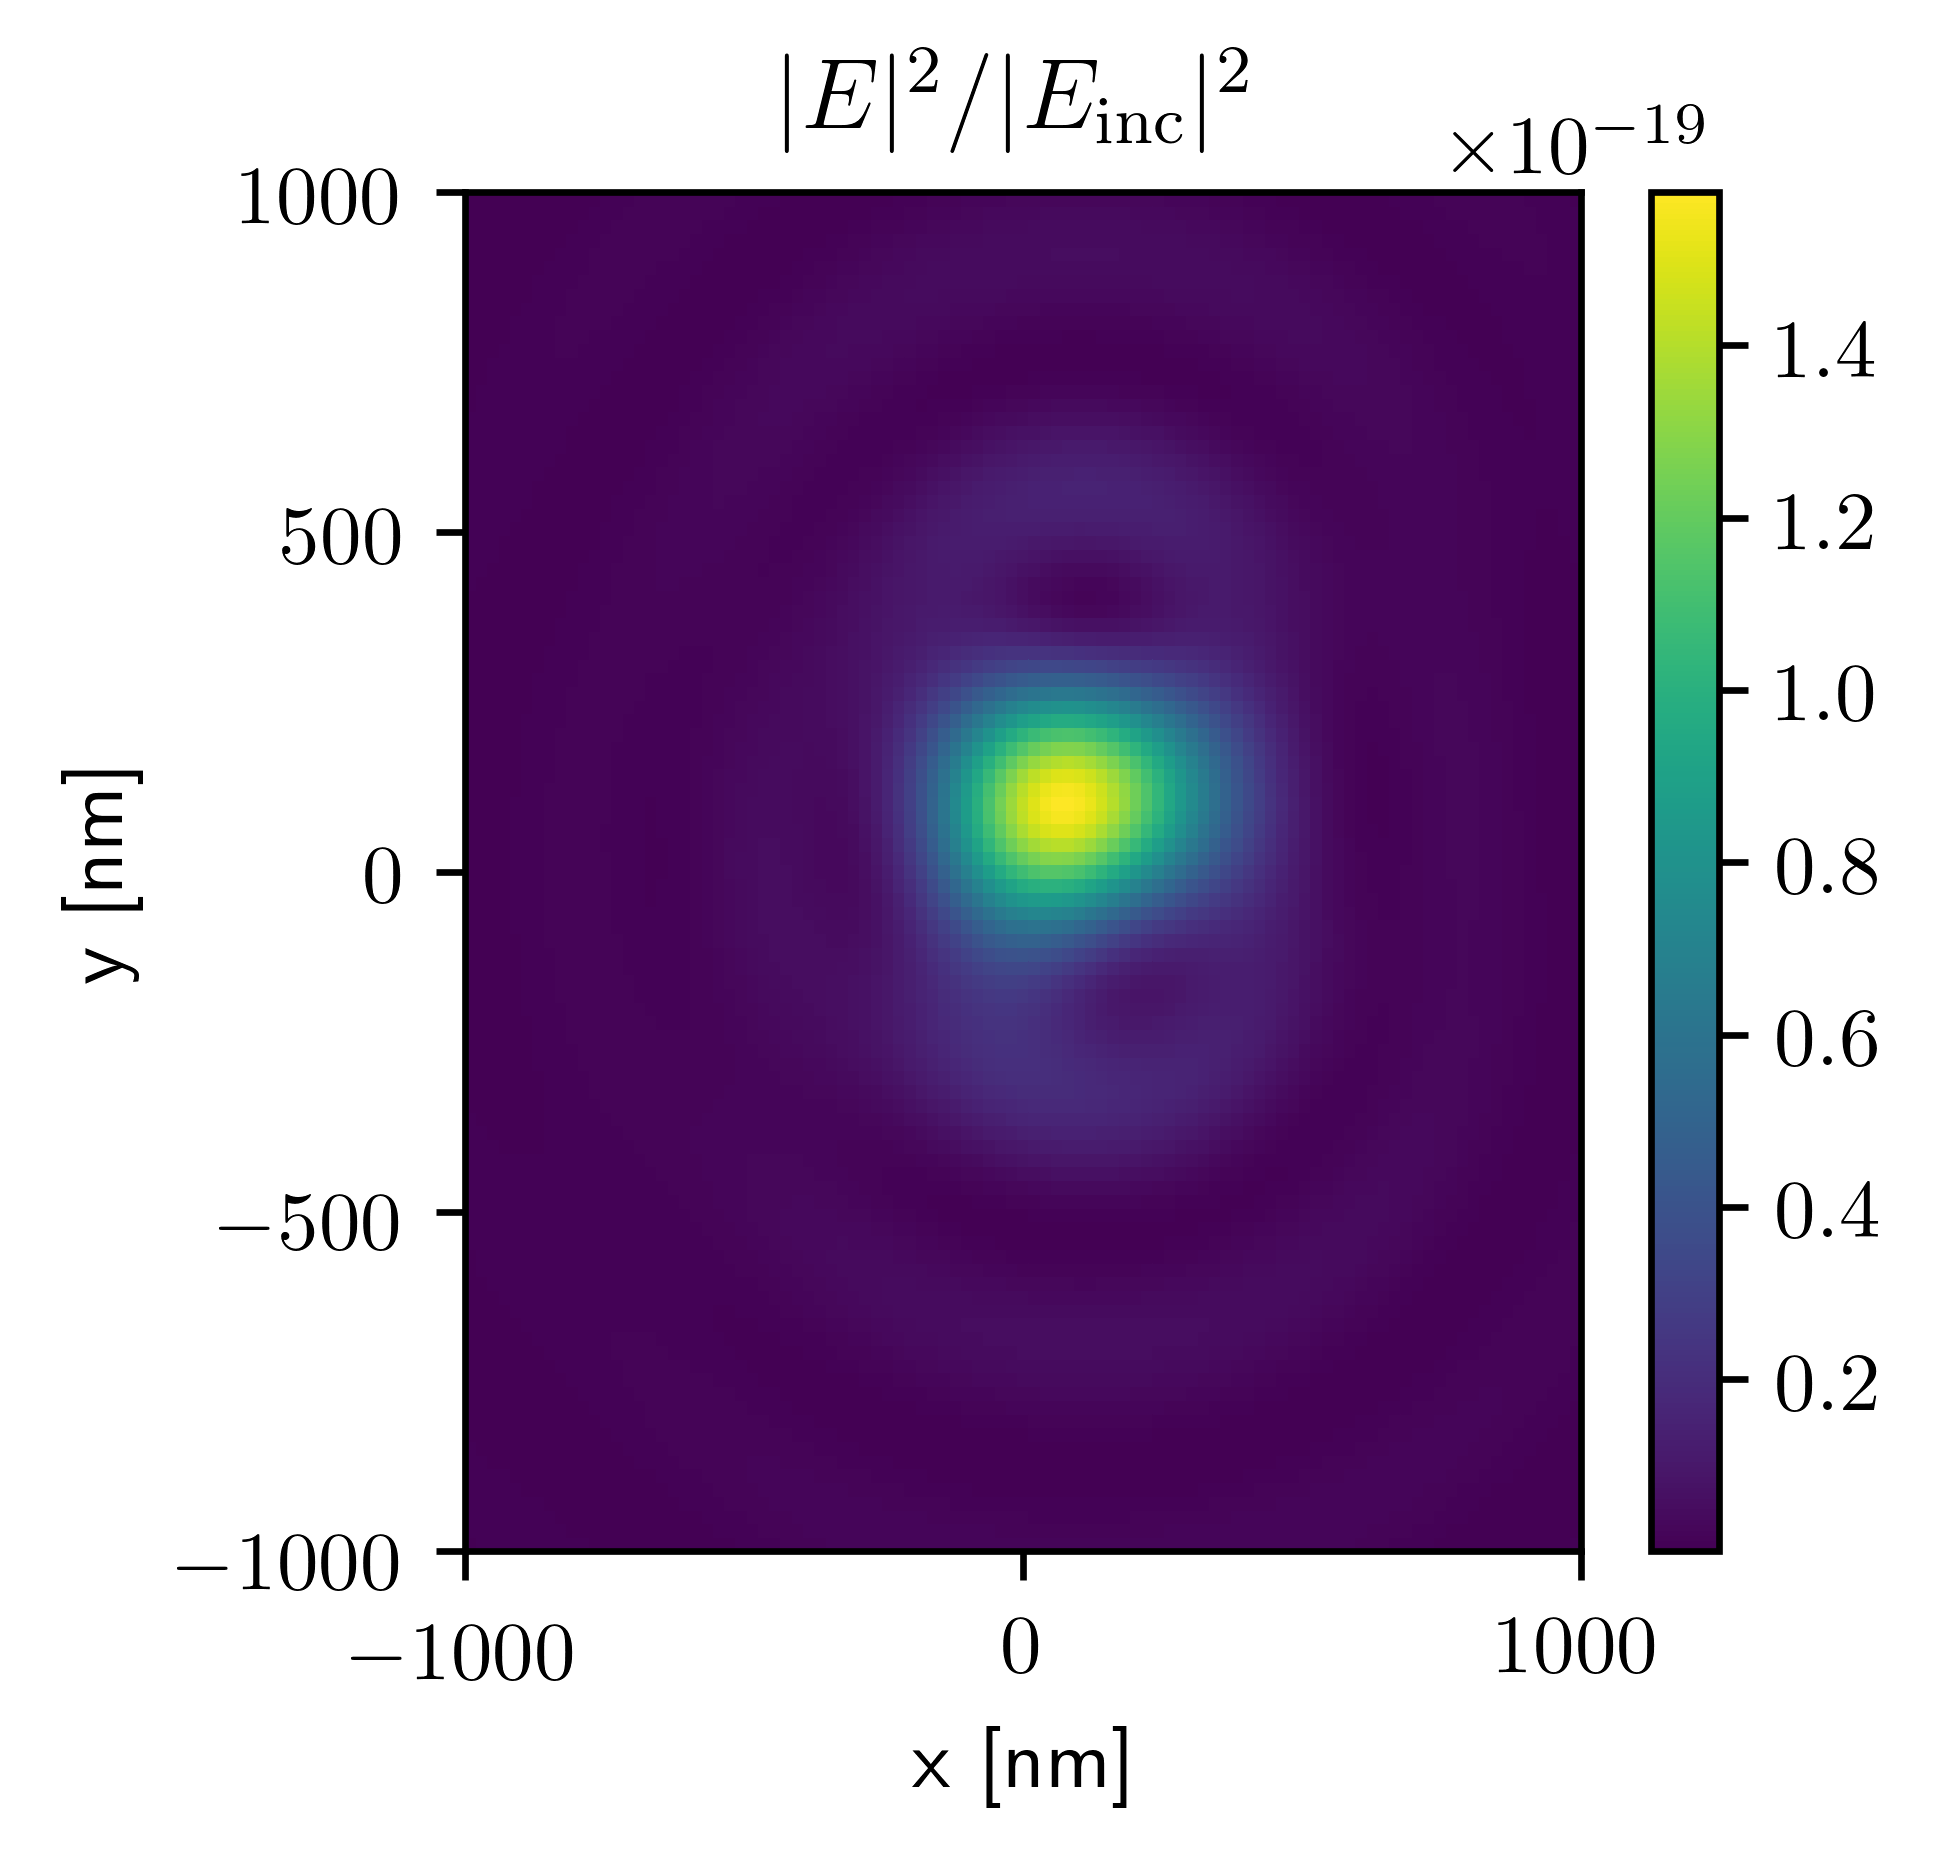

In [248]:
test_fit_inst.plot_image_from_params([100,100,0])

Ok lets keep this really simple

In [253]:
test_exp_instance_h = MolCoupNanoRodExp(np.array([[200, 200, 0]]), 0)
test_fit_inst = FitModelToData(test_exp_instance_h.trial_images)

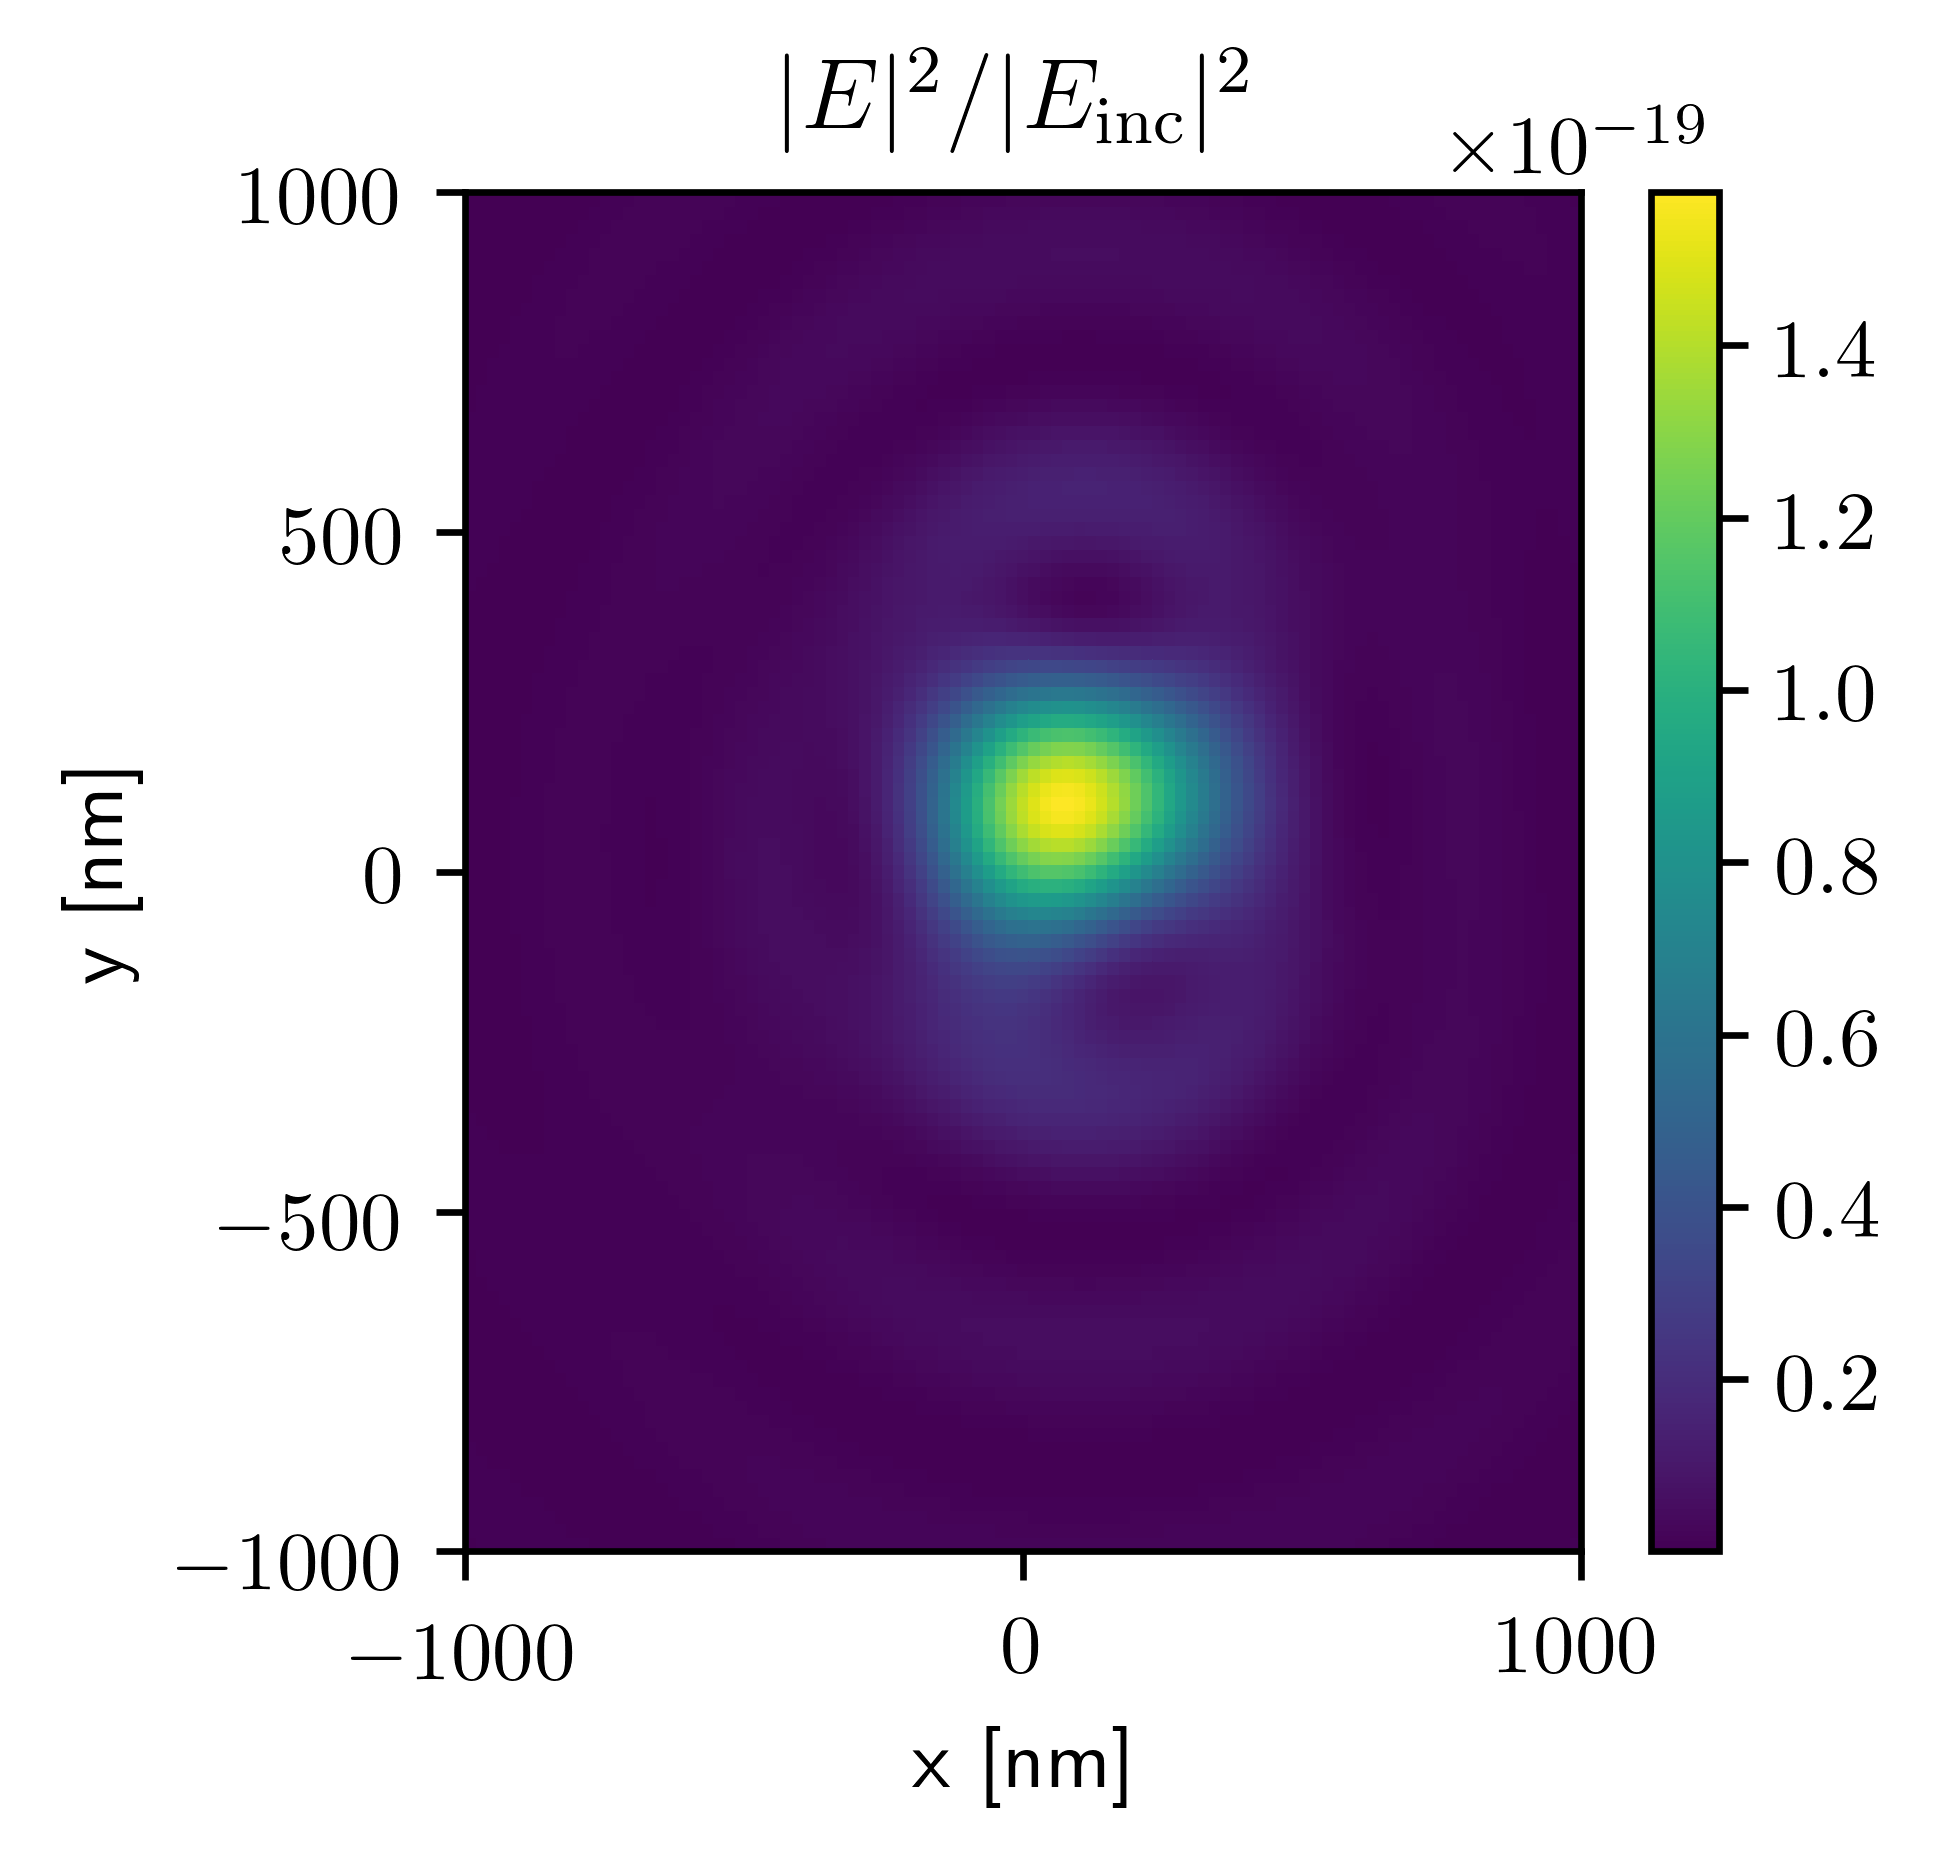

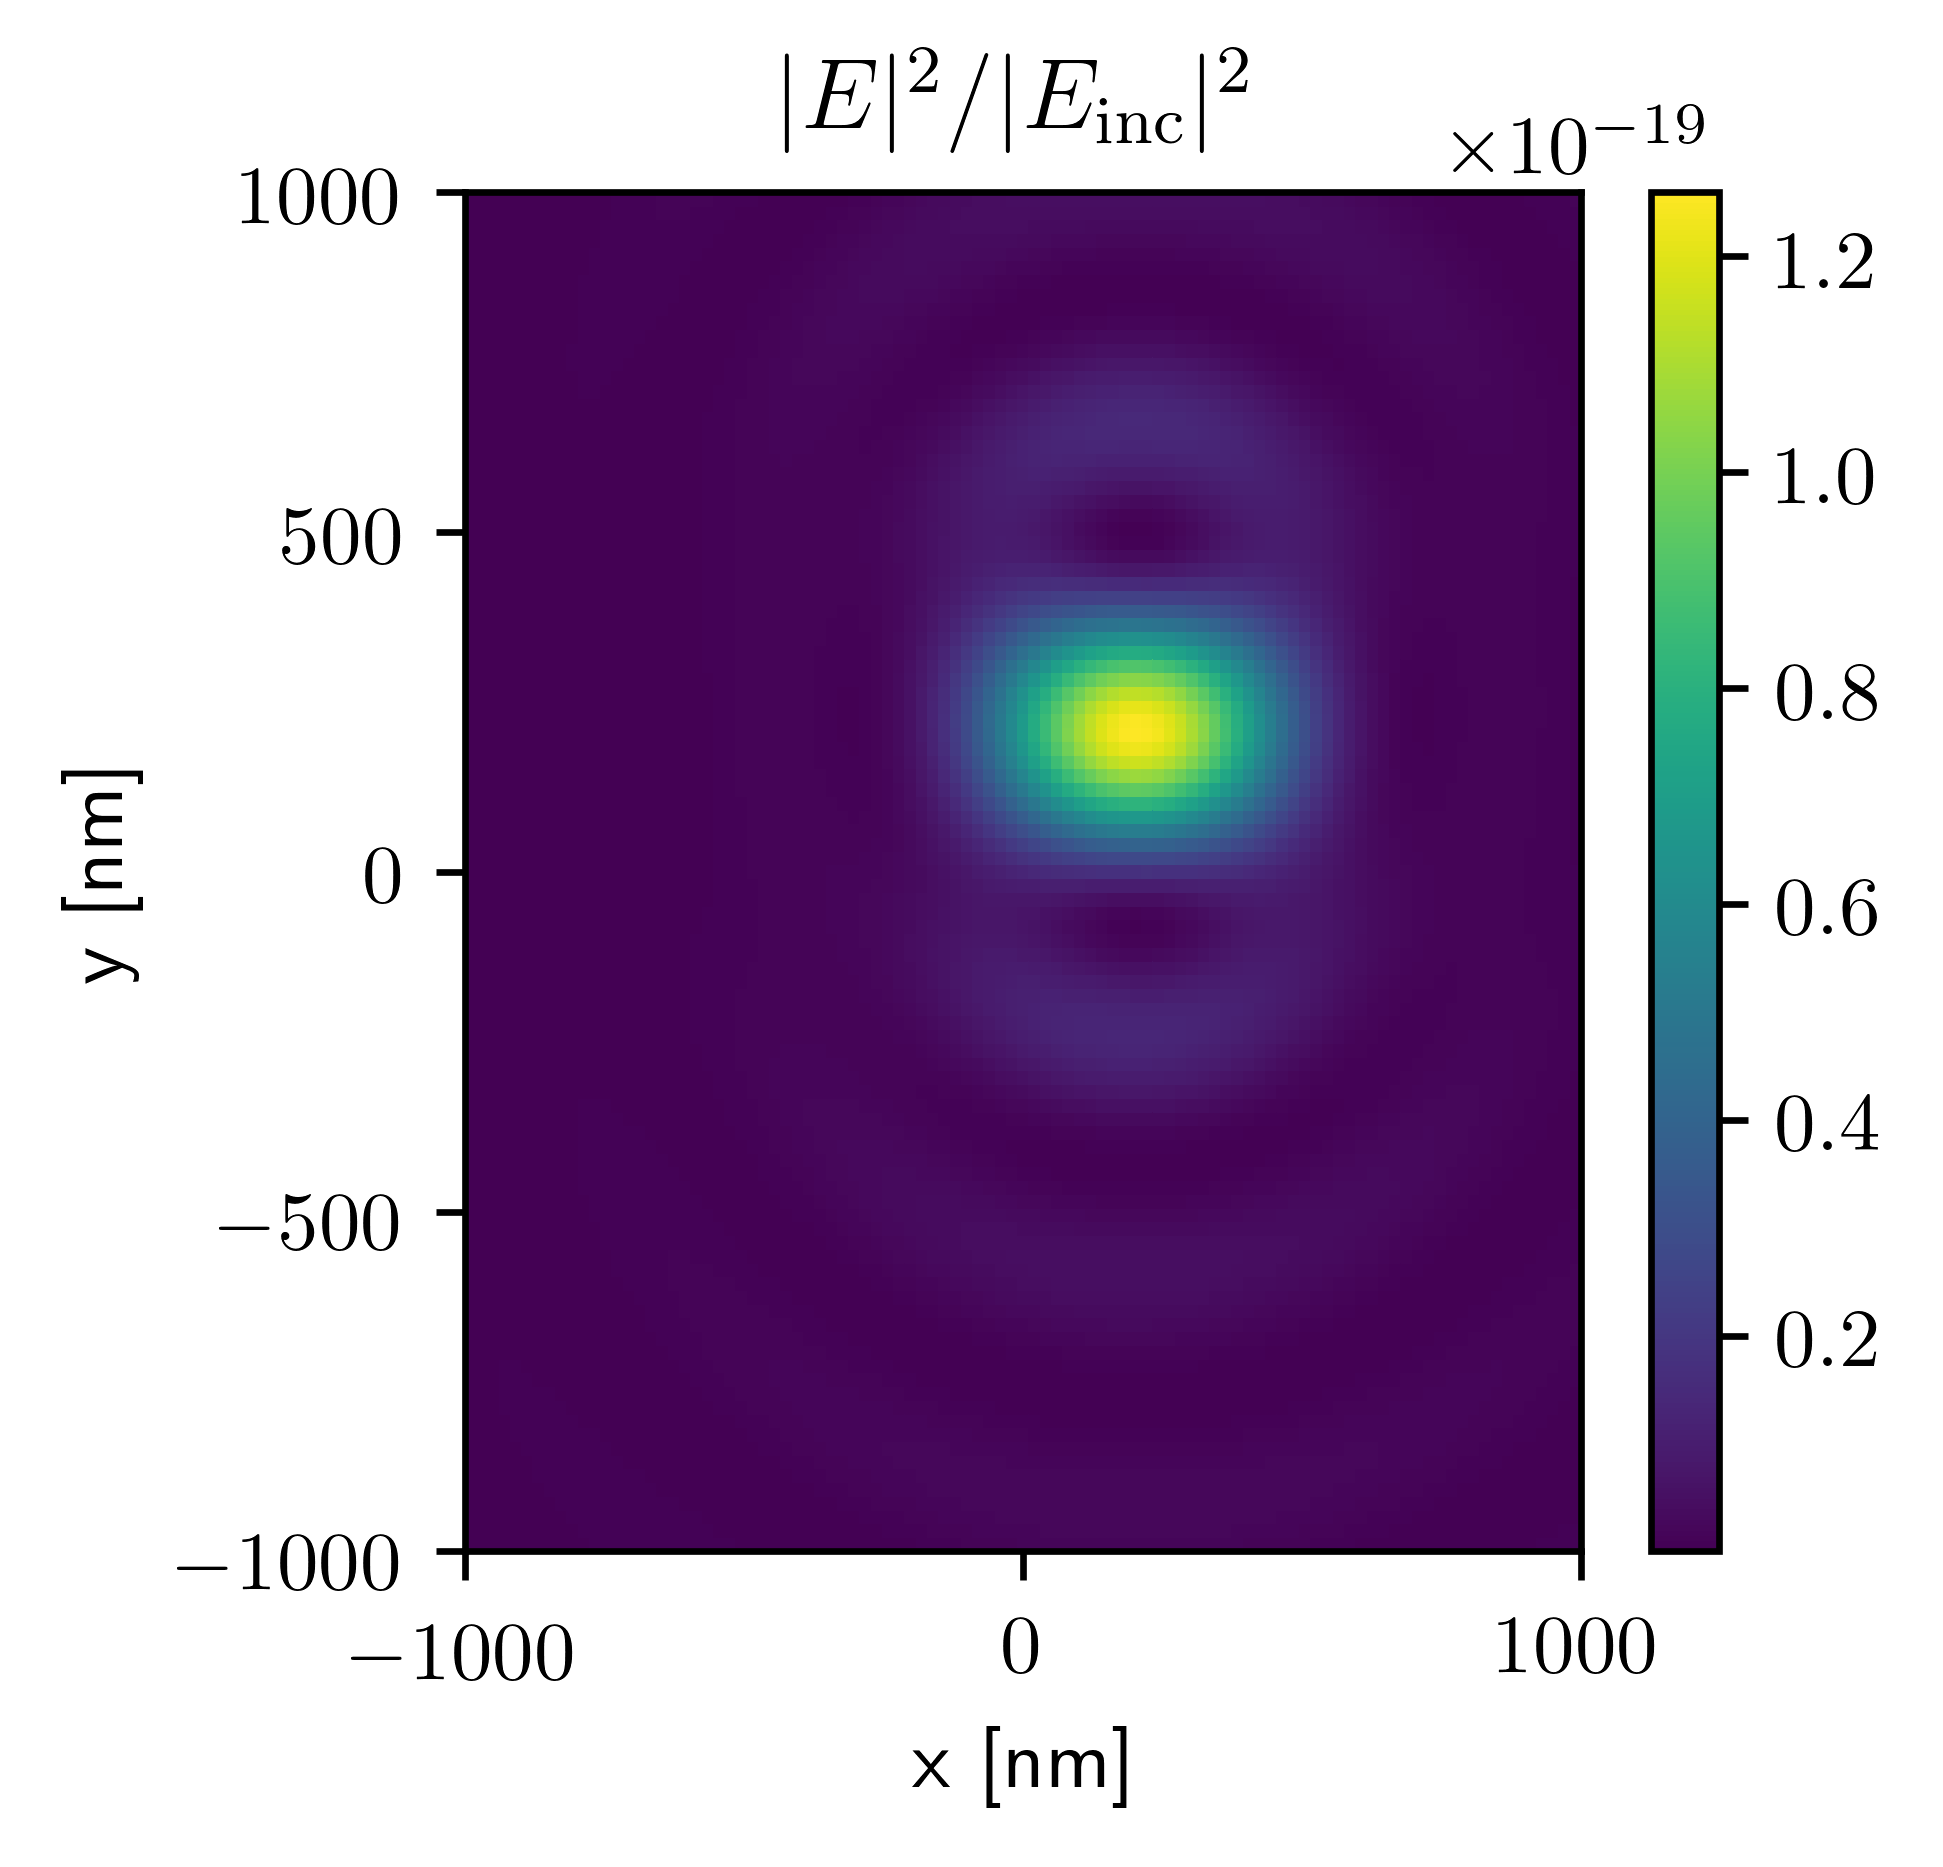

In [254]:
test_fit_inst.plot_image_from_params([100,100,0])
test_exp_instance_h.plot_fields(0)

In [124]:
class ModelImageForFit(MolCoupNanoRodExp):
    '''based on class instance
       MolCoupNanoRodExp(locations, mol_angle=0, plas_angle=np.pi/2, 
                         x_obv_grid=eye[1], y_obv_grid=eye[2]) 
    input parameters;
       locations: should be single molecule location in 2D numpy array, np.array([[x,y,0]])
       mol_angle=0: 
       plas_angle=np.pi/2:
       x_obv_grid=eye[1]: 
       y_obv_grid=eye[2]:
    '''
    if type(locations) != np.ndarray:
        if type(locations) == list:
            if len(locations) == 3:
                locations = np.array([locations])
            else: raise Error('locations is list but not length 3')
    
    locations = np.atleast_2d()
    if locations.shape[0] != 1:
        else: raise Error('first dimension of locations is not length 1')
                
                
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2, 
                         x_obv_grid=eye[1], y_obv_grid=eye[2]
                 ):
        super().__init__(locations, mol_angle, plas_angle, x_obv_grid, y_obv_grid)
        self.raveled_model = self.trial_images[0].ravel()

class ModelFitToData(ModelImageForFit): 
    '''takes input: (fit_params, raveled_image_data )
        fit_params: [molecule_location, mol_angle]
        raveled_image_data: ...
    '''
    def __init__(self, fit_params, raveled_image_data):
        super().__init__(locations=fit_params[0], mol_angle=fit_params[1], plas_angle=fit_params[0]
                         ):
        self.normed_raveled_image_data = normed_raveled_image_data
    
    self.calculate_molecule_location_and_orientation(normed_raveled_image_data)

    def calculate_apparent_centroids(self, images):
        ## calculate index of maximum in each image, going to use this for the initial position guess 
        num_of_images = images.shape[0]

        apparent_centroids_xy = np.zeros((num_of_images,2))

        max_positions = calculate_max_xy(images)

        for i in np.arange(num_of_images):
            x0 = max_positions[0][i]
            y0 = max_positions[1][i]        
            params0 = (1,x0,y0,100, 100, 0,0)
            args=tuple(images[i]/np.max(images[i]))
            fit_gaussian = opt.least_squares(self.misloc_data_minus_model, params0, args=args)
            resulting_fit_params = fit_gaussian['x']
            fit_result = twoD_Gaussian(
                (eye[1]/nm, eye[2]/nm), ## tuple of meshed (x,y) values
                *resulting_fit_params
                )
            centroid_xy = resulting_fit_params[1:3]
            apparent_centroids_xy[i] = centroid_xy
        ## define locations for each maximum in physical coordinate system

        return apparent_centroids_xy.T  ## returns [x_cen(s), y_cen(s)]

    def misloc_data_minus_model(self, fit_params, *normed_raveled_image_data):
        ''' fit image model to data 
        '''
        gaus = twoD_Gaussian(
            (x_obv_grid, y_obv_grid),
            *fit_params ## ( A, xo, yo, sigma_x, sigma_y, theta, offset)
            )

        return self.raveled_model - normed_raveled_image_data

IndentationError: expected an indented block (<ipython-input-124-a4286df1eec9>, line 13)